# Fit the ratio of resolved binaries over unresolved binaries of 3 different $q_{\rm lim}$ as a function of distance and use it to compute the total binary fraction and its uncertainties for the catalogue with MCMC unresolved BF results.

In [1]:
import os
import numpy as np
from scipy.stats import linregress
from scipy import interpolate
import astropy
from astropy.table import Table, vstack, join, hstack
from matplotlib import pyplot as plt
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 14}
import matplotlib.font_manager as font_manager
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

## 1. Counting resolved binaries in the GOG OC simulations

We first define a function that computes the unresolved binary fraction:

$$ f_b^{\rm resolved}(q>q_{lim}) = \frac{N_{\rm resolved\ systems\ with\ q>q_{lim}}}{N_{\rm all\ systems}}
= \frac{N_{\rm resolved\ systems\ with\ q>q_{lim}}}{N_{\rm resolved\ systems\ with\ q>q_{lim}} + N_{\rm unresolved\ systems\ with\ q>q_{lim}} + N_{\rm single\ stars}}$$

In [2]:
def compute_resolved_fb(simclus, qlim = 0.55):
    # Get systems: we use the Gaia file becasue this is how the OC would be seen if observed
    primaries   = ["A" in id for id in simclus["#ID"]]
    secondaries = ["B" in id for id in simclus["#ID"]]
    systems     = ["*" in id for id in simclus["#ID"]]
    # Compute mass ratios of the resolved systems
    # This works because both lists have the same length (for each component A there is the respective component B) and
    # because they have the same order: dividing their respective positions gives the ratios of components of the same
    # system
    massratios  = simclus["Mass"][secondaries] / simclus["Mass"][primaries]
    # Get number of resolved systems with q > qlim:
    Nsys_res_q_gtr_qlim = np.sum( massratios > qlim )
    # Get the number of all systems: the length of the catalogue minus the number of secondaries (found summing
    # all the list of True/False considering True=1 and False=0, and there is True when ID has a "B"):
    N_all = len(simclus) - np.sum(secondaries)
    # Return resolved fb:
    return np.round(Nsys_res_q_gtr_qlim / N_all, 3)


A similar function computes the resolved binary fraction:

$$ f_b^{\rm unresolved}(q>q_{lim}) = \frac{N_{\rm unresolved\ systems\ with\ q>q_{lim}}}{N_{\rm all\ systems}}
= \frac{N_{\rm unresolved\ systems\ with\ q>q_{lim}}}{N_{\rm resolved\ systems\ with\ q>q_{lim}} + N_{\rm unresolved\ systems\ with\ q>q_{lim}} + N_{\rm single\ stars}}$$

In [3]:
def compute_unresolved_fb(simclus_Gaia, simclus_UniversModel, qlim = 0.55):
    # Get systems: we use the Gaia file becasue this is how the OC would be seen if observed
    primaries_gaia   = ["A" in id for id in simclus_Gaia["#ID"]]
    secondaries_gaia = ["B" in id for id in simclus_Gaia["#ID"]]
    unresolved_systems     = ["*" in id for id in simclus_Gaia["#ID"]]
    
    # Compute mass ratios of the unresolved systems
    # This works because both lists have the same length (for each component A there is the respective component B) and
    # because they have the same order: dividing their respective positions gives the ratios of components of the same
    # system
    unresolved_systems_ids = list(simclus_Gaia["#ID"][unresolved_systems])
    massratios_unres_sys = []
    for ii in np.arange(0, len(unresolved_systems_ids)):
        primary = simclus_UniversModel["Mass"][ simclus_UniversModel["#ID"] == ((unresolved_systems_ids[ii])[:-1] + "A" )]
        secondary = simclus_UniversModel["Mass"][ simclus_UniversModel["#ID"] == ((unresolved_systems_ids[ii])[:-1] + "B" )]
        massratio = float(secondary)/(float(primary))
        massratios_unres_sys.append(massratio)

    massratios_unres_sys_col = astropy.table.Column(massratios_unres_sys)
    # Get number of unresolved systems with q > qlim:
    Nsys_unres_q_gtr_qlim = np.sum( massratios_unres_sys_col > qlim )
    # Get the number of all systems: the length of the catalogue minus the number of secondaries (found summing
    # all the list of True/False considering True=1 and False=0, and there is True when ID has a "B"):
    N_all = len(simclus_Gaia) - np.sum(secondaries_gaia)
    # Return unresolved fb:
    return np.round(Nsys_unres_q_gtr_qlim / N_all, 3)


## 2. Loop over simulated clusters and distances

We use custom GOG simulations of OC populations at different distances (created by E. Massana on May 27, 2022).
The assumed limiting resolution of Gaia is 500 mas.

In [4]:
simdir = "data/OC_sims_distances/"

cluslist = ["Alessi_21", "ASCC_21", "Ruprecht_147", "UPK_53"]
distances= [50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600]  # in pc

In [5]:
# Create empty arrays
# They have len(cluslist) elements, each of them being a list consisting of len(distances) values which contain the
# resolved binary fraction for each of the 10 distances for that OC and that q_lim.
fb_res_qlim045 = np.zeros((len(cluslist), len(distances)))
fb_res_qlim06 = np.zeros((len(cluslist), len(distances)))
fb_res_qlim065 = np.zeros((len(cluslist), len(distances)))

fb_unres_qlim045 = np.zeros((len(cluslist), len(distances)))
fb_unres_qlim06 = np.zeros((len(cluslist), len(distances)))
fb_unres_qlim065 = np.zeros((len(cluslist), len(distances)))

In [6]:
# For each OC
for ii in np.arange(len(cluslist)):
    print("Analysing simulations of ", cluslist[ii])
    # For each distance:
    for jj in np.arange(len(distances)):
        # Read simulation
        simcOC_gaia = Table.read(simdir + cluslist[ii] + "_isochrone_m_10000_" + 
                             str(distances[jj]) + "_Gaia.csv", format="csv")
        simOC_UniversModel = Table.read(simdir + cluslist[ii] + "_isochrone_m_10000_" + 
                             str(distances[jj]) + "_UniversModel.csv", format="csv")
        # Compute fb_resolved
        fb_res_qlim045[ii, jj] = compute_resolved_fb(simcOC_gaia, qlim = 0.45)  # MCMC 10th percentile
        fb_res_qlim06[ii, jj]  = compute_resolved_fb(simcOC_gaia, qlim = 0.6)   # MCMC median
        fb_res_qlim065[ii, jj] = compute_resolved_fb(simcOC_gaia, qlim = 0.65)  # MCMC 90th percentile
        # Compute fb_unresolved
        fb_unres_qlim045[ii, jj] = compute_unresolved_fb(simcOC_gaia, simOC_UniversModel, qlim = 0.45)
        fb_unres_qlim06[ii, jj]  = compute_unresolved_fb(simcOC_gaia, simOC_UniversModel, qlim = 0.6)
        fb_unres_qlim065[ii, jj] = compute_unresolved_fb(simcOC_gaia, simOC_UniversModel, qlim = 0.65)

Analysing simulations of  Alessi_21
Analysing simulations of  ASCC_21
Analysing simulations of  Ruprecht_147
Analysing simulations of  UPK_53


# $q_{lim}=0.6$ (median for the selected simulated OCs studied through MCMC)

In [7]:
distances_all = []
fb_res_06_all = []
fb_unres_06_all = []
ratio_fb_res_over_unres = []
for ii in np.arange(0, 4):
    for jj in np.arange(0, len(distances)):
        distances_all.append(np.log10(distances[jj]))
        fb_res_06_all.append(fb_res_qlim06[ii][jj])
        fb_unres_06_all.append(fb_unres_qlim06[ii][jj])
        ratio_fb_res_over_unres.append(fb_res_qlim06[ii][jj]/fb_unres_qlim06[ii][jj])

\Quadratic fit for all 4 OCs: y=a·x^2+b·x+c
  a: 0.16635556281903421 +- 0.01884632908632048
  b: -1.1683799046724241 +- 0.09390577558453594
  c: 2.1355268933311566 +- 0.11293056179722583


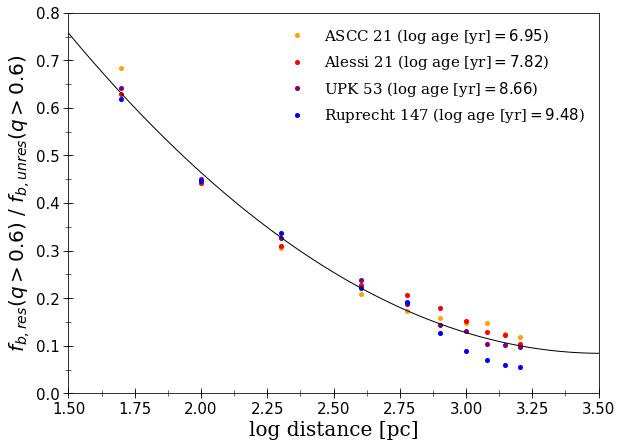

In [8]:
xpts = np.log10(distances)

coeffs_all, covariance_matrix_all = np.polyfit(distances_all, ratio_fb_res_over_unres, 2, full=False, cov=True)
all_fit = np.poly1d(coeffs_all)
a_06 = coeffs_all[0]
b_06 = coeffs_all[1]
c_06 = coeffs_all[2]
print("\Quadratic fit for all 4 OCs: y=a·x^2+b·x+c")
print("  a:", a_06, "+-", np.sqrt(covariance_matrix_all[0][0]))
print("  b:", b_06, "+-", np.sqrt(covariance_matrix_all[1][1]))
print("  c:", c_06, "+-", np.sqrt(covariance_matrix_all[2][2]))

fig = plt.figure(frameon=True)
ax  = plt.subplot(111)
fig.set_size_inches(9.5,7)  #(width, height)
xpts_linearfits = np.linspace(1.5, 3.5, 1000)
plt.plot(xpts, fb_res_qlim06[1]/fb_unres_qlim06[1], marker="o", markersize=4, linewidth=0, color="orange", label=r"ASCC 21 (log age [yr]$=6.95$)")
plt.plot(xpts, fb_res_qlim06[0]/fb_unres_qlim06[0], marker="o", markersize=4, linewidth=0, color="red", label=r"Alessi 21 (log age [yr]$=7.82$)")
plt.plot(xpts, fb_res_qlim06[3]/fb_unres_qlim06[3], marker="o", markersize=4, linewidth=0, color="purple", label=r"UPK 53 (log age [yr]$=8.66$)")
plt.plot(xpts, fb_res_qlim06[2]/fb_unres_qlim06[2], marker="o", markersize=4, linewidth=0, color="blue", label=r"Ruprecht 147 (log age [yr]$=9.48$)")
plt.plot(xpts_linearfits, all_fit(xpts_linearfits), color="black", linewidth=1.0, label='_nolegend_')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('log distance [pc]',  fontsize = 20, fontdict=font)
plt.ylabel('${f_{b,res}(q>0.6)}$ / ${f_{b,unres}(q>0.6)}$',  fontsize = 20, fontdict=font)
plt.xlim(1.5, 3.5)
plt.ylim(0.0, 0.8)
#plt.xscale('log')
ax.tick_params(which="major", direction='inout', length=10.)
ax.tick_params(which="minor", direction='inout', length=6.)
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

font_legend = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal', size=15)
plt.legend(fontsize=21, prop=font_legend, framealpha=0.)
plt.savefig("im/fb_res_qlarger06_4OCs_logdist_fitdeg2.png")
plt.show()

# $q_{lim}=0.45$ ($16^{\rm th}$ percentile for the selected simulated OCs studied through MCMC)

In [9]:
distances_all = []
fb_res_045_all = []
fb_unres_045_all = []
ratio_fb_res_over_unres_045 = []
for ii in np.arange(0, 4):
    for jj in np.arange(0, len(distances)):
        distances_all.append(np.log10(distances[jj]))
        fb_res_045_all.append(fb_res_qlim045[ii][jj])
        fb_unres_045_all.append(fb_unres_qlim045[ii][jj])
        ratio_fb_res_over_unres_045.append(fb_res_qlim045[ii][jj]/fb_unres_qlim045[ii][jj])

Quadratic fit for all 4 OCs: y=a·x^2+b·x+c
  a: 0.161278019961616 +- 0.019345448815463216
  b: -1.1731761597612407 +- 0.09639274400475274
  c: 2.198247185659971 +- 0.11592137614404105


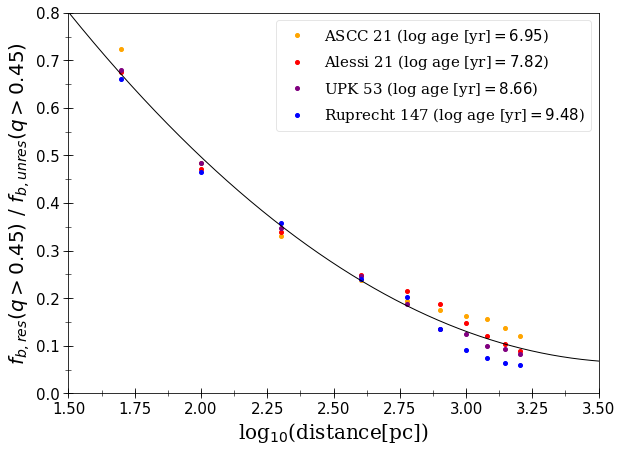

In [10]:
xpts = np.log10(distances)

coeffs_all, covariance_matrix_all = np.polyfit(distances_all, ratio_fb_res_over_unres_045, 2, full=False, cov=True)
all_fit = np.poly1d(coeffs_all)
a_045 = coeffs_all[0]
b_045 = coeffs_all[1]
c_045 = coeffs_all[2]
print("Quadratic fit for all 4 OCs: y=a·x^2+b·x+c")
print("  a:", a_045, "+-", np.sqrt(covariance_matrix_all[0][0]))
print("  b:", b_045, "+-", np.sqrt(covariance_matrix_all[1][1]))
print("  c:", c_045, "+-", np.sqrt(covariance_matrix_all[2][2]))

fig = plt.figure(frameon=True)
ax  = plt.subplot(111)
fig.set_size_inches(9.5,7)  #(width, height)
xpts_linearfits = np.linspace(1.5, 3.5, 1000)
plt.plot(xpts, fb_res_qlim045[1]/fb_unres_qlim045[1], marker="o", markersize=4, linewidth=0, color="orange", label=r"ASCC 21 (log age [yr]$=6.95$)")
plt.plot(xpts, fb_res_qlim045[0]/fb_unres_qlim045[0], marker="o", markersize=4, linewidth=0, color="red", label=r"Alessi 21 (log age [yr]$=7.82$)")
plt.plot(xpts, fb_res_qlim045[3]/fb_unres_qlim045[3], marker="o", markersize=4, linewidth=0, color="purple", label=r"UPK 53 (log age [yr]$=8.66$)")
plt.plot(xpts, fb_res_qlim045[2]/fb_unres_qlim045[2], marker="o", markersize=4, linewidth=0, color="blue", label=r"Ruprecht 147 (log age [yr]$=9.48$)")
plt.plot(xpts_linearfits, all_fit(xpts_linearfits), color="black", linewidth=1.0, label='_nolegend_')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('log$_{10}$(distance[pc])', fontsize = 20, fontdict=font)
plt.ylabel('${f_{b,res}(q>0.45)}$ / ${f_{b,unres}(q>0.45)}$', fontsize = 20, fontdict=font)
plt.xlim(1.5, 3.5)
plt.ylim(0.0, 0.8)
ax.tick_params(which="major", direction='inout', length=10.)
ax.tick_params(which="minor", direction='inout', length=6.)
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
font_legend = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal', size=15)
plt.legend(fontsize=13, prop=font_legend, framealpha=0.5)
#plt.savefig("im/fb_res_qlarger045_4OCs_logdist_fitdeg2.png")
plt.show()

# $q_{lim}=0.65$ ($84^{\rm th}$ percentile for the selected simulated OCs studied through MCMC)

In [11]:
distances_all = []
fb_res_065_all = []
fb_unres_065_all = []
ratio_fb_res_over_unres_065 = []
for ii in np.arange(0, 4):
    for jj in np.arange(0, len(distances)):
        distances_all.append(np.log10(distances[jj]))
        fb_res_065_all.append(fb_res_qlim065[ii][jj])
        fb_unres_065_all.append(fb_unres_qlim065[ii][jj])
        ratio_fb_res_over_unres_065.append(fb_res_qlim065[ii][jj]/fb_unres_qlim065[ii][jj])

Quadratic fit for all 4 OCs: y=a·x^2+b·x+c
  a: 0.16331281582693938 +- 0.020092271909656952
  b: -1.1436128517950548 +- 0.10011394623800941
  c: 2.088678257309876 +- 0.12039647318835926


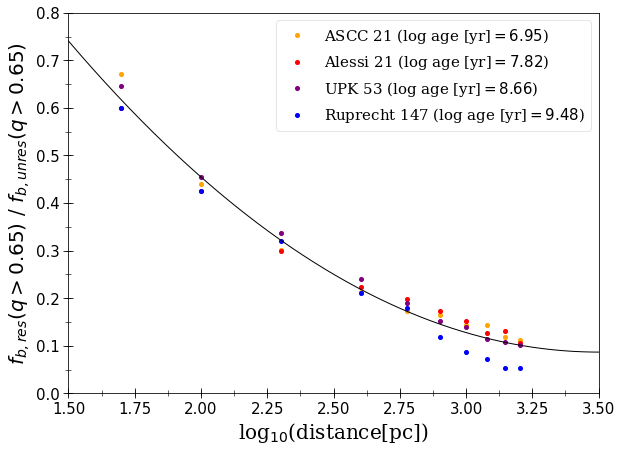

In [12]:
xpts = np.log10(distances)

coeffs_all, covariance_matrix_all = np.polyfit(distances_all, ratio_fb_res_over_unres_065, 2, full=False, cov=True)
all_fit = np.poly1d(coeffs_all)
a_065 = coeffs_all[0]
b_065 = coeffs_all[1]
c_065 = coeffs_all[2]
print("Quadratic fit for all 4 OCs: y=a·x^2+b·x+c")
print("  a:", a_065, "+-", np.sqrt(covariance_matrix_all[0][0]))
print("  b:", b_065, "+-", np.sqrt(covariance_matrix_all[1][1]))
print("  c:", c_065, "+-", np.sqrt(covariance_matrix_all[2][2]))

fig = plt.figure(frameon=True)
ax  = plt.subplot(111)
fig.set_size_inches(9.5,7)  #(width, height)
xpts_linearfits = np.linspace(1.5, 3.5, 1000)
plt.plot(xpts, fb_res_qlim065[1]/fb_unres_qlim065[1], marker="o", markersize=4, linewidth=0, color="orange", label=r"ASCC 21 (log age [yr]$=6.95$)")
plt.plot(xpts, fb_res_qlim065[0]/fb_unres_qlim065[0], marker="o", markersize=4, linewidth=0, color="red", label=r"Alessi 21 (log age [yr]$=7.82$)")
plt.plot(xpts, fb_res_qlim065[3]/fb_unres_qlim065[3], marker="o", markersize=4, linewidth=0, color="purple", label=r"UPK 53 (log age [yr]$=8.66$)")
plt.plot(xpts, fb_res_qlim065[2]/fb_unres_qlim065[2], marker="o", markersize=4, linewidth=0, color="blue", label=r"Ruprecht 147 (log age [yr]$=9.48$)")
plt.plot(xpts_linearfits, all_fit(xpts_linearfits), color="black", linewidth=1.0, label='_nolegend_') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('log$_{10}$(distance[pc])', fontsize = 20, fontdict=font)
plt.ylabel('${f_{b,res}(q>0.65)}$ / ${f_{b,unres}(q>0.65)}$', fontsize = 20, fontdict=font)
plt.xlim(1.5, 3.5)
plt.ylim(0.0, 0.8)
ax.tick_params(which="major", direction='inout', length=10.)
ax.tick_params(which="minor", direction='inout', length=6.)
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
font_legend = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal', size=15)
plt.legend(fontsize=13, prop=font_legend, framealpha=0.5)
#plt.savefig("im/fb_res_qlarger065_4OCs_logdist_fitdeg2.png")
plt.show()

## 3. Adding unresolved and total binary fractions to the simulated catalogue

In [13]:
# Catalogue of the 324 simulated OCs:
cat_sim = Table.read("data/Catalogue_sim_324OCs_MCMC_DEFINITIVE.fits", format="fits")

We compute the total binary fraction according to the following formulae:

![Formulae_image](im/Formulae_fb_tot.png)

In [14]:
# Columns with the ratios of resolved over unresolved BF of the q>q_lim in each case, for the simulated CMDs:
cat_sim['fb_res_grt06_over_fb_unres_grt06']  = a_06 * ((np.log10(cat_sim["DistPc"]))**2) + \
                                                        b_06 *  (np.log10(cat_sim["DistPc"])) + c_06
cat_sim['fb_res_grt065_over_fb_unres_grt065']= a_065* ((np.log10(cat_sim["DistPc"]))**2) + \
                                                        b_065*  (np.log10(cat_sim["DistPc"])) + c_065
cat_sim['fb_res_grt045_over_fb_unres_grt045']= a_045* ((np.log10(cat_sim["DistPc"]))**2) + \
                                                        b_045*  (np.log10(cat_sim["DistPc"])) + c_045
# Column of the median and percentiles of the total BF:
cat_sim['mean_fb_tot_greater06'] = cat_sim["mean_fb_50"] * \
                                            (1.0 + cat_sim["fb_res_grt06_over_fb_unres_grt06"])
cat_sim['mean_fb_tot_greater065']= np.sqrt(  (cat_sim["mean_fb_sigu"] * 
                                                       (1.0 + cat_sim["fb_res_grt06_over_fb_unres_grt06"]))**2 
                                                    + (cat_sim["mean_fb_50"] * 
                                                       (abs(cat_sim["fb_res_grt065_over_fb_unres_grt065"] 
                                                            - cat_sim["fb_res_grt06_over_fb_unres_grt06"])))**2
                                                    )
cat_sim['mean_fb_tot_greater045']= np.sqrt(  (cat_sim["mean_fb_sigl"] * 
                                                       (1.0 + cat_sim["fb_res_grt06_over_fb_unres_grt06"]))**2 
                                                    + (cat_sim["mean_fb_50"] * 
                                                       (abs(cat_sim["fb_res_grt06_over_fb_unres_grt06"] 
                                                            - cat_sim["fb_res_grt045_over_fb_unres_grt045"])))**2
                                                    )


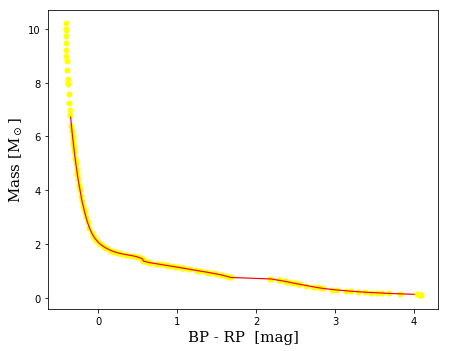

In [16]:
isoc = Table.read("data/isoch_logage_7point2.txt", format="ascii")
isoc_sel_range = isoc[ isoc["Mass"] <= 10.5 ]
colour  = isoc_sel_range['G_BPftmag']-isoc_sel_range['G_RPmag']
mass = isoc_sel_range['Mass']
f_mass = interpolate.interp1d(colour, mass)

fig = plt.figure(frameon=True)
fig.set_size_inches(7,5.5)  #(width, height)
plt.xlabel('BP - RP  [mag]', fontsize = 15, fontdict=font)
plt.ylabel(r'Mass [M$_\odot$]', fontsize = 15, fontdict=font)
x = np.linspace(-0.35, 4., 1000)
plt.plot(colour, mass,  marker="o", linewidth=0, markersize=5, color ="yellow")
plt.plot(x, f_mass(x), color="red", linewidth=1.2)
plt.show()

In [18]:
cat_sim_BP_RP_range = Table.read("data/sim_OCs_BP_RP_0_range.txt", format="ascii")
print(cat_sim_BP_RP_range)
print("Our 324 simulated OCs have BP-RP_0 in the range: [",
      np.min(cat_sim_BP_RP_range['BP_RP_0_min']), ", ",
     np.max(cat_sim_BP_RP_range['BP_RP_0_max']-0.2), "].")
print("Therefore, the isochrone used is suited for the range in BP-RP_0 of our simulated OCs.")

 cluster   nb_members  logAge      BP_RP_0_min         BP_RP_0_max    
---------- ---------- ------- --------------------- ------------------
   ASCC_10        113 8.41996   0.08163200000000148 1.3655820540540526
  ASCC_101         81  8.6902   0.22041940540540572 2.3668747567567583
  ASCC_108        199 8.02938 -0.029835729729728616 1.5174434054054051
   ASCC_11        227 8.38917   0.09152610810810846 1.4572928108108119
  ASCC_111         83 8.43933   0.08387583783783864 1.7696216756756786
  ASCC_113        290 8.45939   0.12467864864864736  2.091971243243241
  ASCC_114        126 7.68034  -0.10578572972972933 1.7386725945945918
  ASCC_115         68 8.12057 -0.010783405405406843  1.760493189189186
   ASCC_12        139 7.96988  -0.04135021621621482 1.3442345945945946
  ASCC_123         45 7.65031  -0.03466227027026997 3.1981034054054045
       ...        ...     ...                   ...                ...
   UPK_640        562 7.39967   -0.1709872432432427 3.8867446486486505
   UPK

In [19]:
cat_sim.add_column(cat_sim_BP_RP_range["BP_RP_0_min"], name="BP_RP_0_min", index=7)
cat_sim.add_column(cat_sim_BP_RP_range["BP_RP_0_max"], name="BP_RP_0_max", index=8)

In [20]:
list_mass_min = []
list_mass_max = []

for ii in np.arange(0, len(cat_sim)):
    list_mass_min.append(f_mass(cat_sim["BP_RP_0_max"][ii]))
    list_mass_max.append(f_mass(cat_sim["BP_RP_0_min"][ii]))

cat_sim['mass_min'] = np.array(list_mass_min)
cat_sim['mass_max'] = np.array(list_mass_max)

In [21]:
a_param = 2.3
cat_sim["mean_mass"] = (1.0 - a_param) * ((cat_sim["mass_max"])**(2.-a_param)-(cat_sim["mass_min"])**(2.-a_param))/((2. - a_param)*((cat_sim["mass_max"])**(1.-a_param)-(cat_sim["mass_min"])**(1.-a_param)))
print(np.min(cat_sim["mean_mass"]))
print(np.max(cat_sim["mean_mass"]))

0.3079319096438535
1.7869517419097847


In [22]:
cat_sim.write("data/Catalogue_sim_OCs_DEFINITIVE.fits", format="fits", overwrite=True)

## 4. Use the same formulae to calculate the total binary fractions for the Gaia OCs
### a.k.a. create the final catalogue

First we read the data tables: the Cantat-Gaudin+2020 catalogue + the results of our binary fraction analysis (which already include the columns referred to the automatic and manual selection of OCs):

In [23]:
# Cantat-Gaudin+2020 catalogue (Table 1)
nntable = Table.read("data/CantatGaudin2020_table1.fits")
nntable["Cluster"]  = np.array([np.char.strip(a, ' ') for a in nntable["Cluster"]], dtype="S17")
# Results of our analysis (separate files for the Tarricq+ and Cantat+ membership lists):
tarricqres = Table.read("data/Catalogue_obs_OCs_MCMC_Tarricq.fits")
tarricqres["clus"] = np.array([np.char.strip(a, ' ') for a in tarricqres["clus"]], dtype="S17")
cantatres  = Table.read("data/Catalogue_obs_OCs_MCMC_Cantat.fits")
cantatres["clus"] = np.array([np.char.strip(a, ' ') for a in cantatres["clus"]], dtype="S17")
# Join the two subtables
jointres   = vstack([tarricqres, cantatres])
jointres["clus"] = np.array([np.char.strip(a, ' ') for a in jointres["clus"]], dtype="S17")
jointres.rename_column('clus', 'Cluster')

In [25]:
names_OCs_Tarricq = np.unique(tarricqres["clus"])
names_OCs_Cantat = np.unique(cantatres["clus"])

list_BP_RP_min = []
list_BP_RP_max = []
for ii in np.arange(0, len(jointres)):
    name_OC = jointres["Cluster"][ii]
    if ((name_OC in names_OCs_Cantat) == True):
        dir_folder = "data/Cantat_selected_members_OCs_younger50Myr/"
        name_file = name_OC+"_sel_MS_members_Cantat.txt"
        table_sel_mem = Table.read(dir_folder+name_file, format="ascii")
    else:
        dir_folder = "data/Tarricq_selected_members_OCs/"
        name_file = name_OC+"_sel_MS_members_Tarricq.txt"
        table_sel_mem = Table.read(dir_folder+name_file, format="ascii")
    list_BP_RP_min.append(np.min(list(table_sel_mem["BP-RP_0"])))
    list_BP_RP_max.append(np.max(list(table_sel_mem["BP-RP_0"])))

jointres['BP_RP_0_min'] = np.array(list_BP_RP_min)
jointres['BP_RP_0_max'] = np.array(list_BP_RP_max)

In [26]:
mergedtable = join(nntable, jointres, join_type='inner')
print("We have (non-curated) binary fraction results for", len(mergedtable), "OCs,", len(tarricqres),
      "from Tarricq+2022 catalogue and", len(cantatres), "from Cantat-Gaudin+2020 catalogue.")

We have (non-curated) binary fraction results for 376 OCs, 248 from Tarricq+2022 catalogue and 128 from Cantat-Gaudin+2020 catalogue.


Clean the results by only choosing those OCs which are correct according to both the automatic selection (ok_fit) and the visual one.

An OC has been correctly studied according to the automatic selection if all the following conditions are met:
* $|\Delta G + 0.75| \leq 0.05$
* $\sigma_{\rm BS} \leq 0.25$
* $\sigma_{\rm SS} \leq 0.2$
* $f_b(16^{\rm th}) + f_b(84^{\rm th}) \leq 0.5$

In [27]:
ok         = (mergedtable["ok_fit"] == 1) * (mergedtable["Fidelity_2"] == 1)
finaltable = mergedtable[ok]

In [29]:
cantat_counter = 0
tarricq_counter = 0

list_mass_min = []
list_mass_max = []
for ii in np.arange(0, len(finaltable)):
    name_OC = finaltable["Cluster"][ii]
    if ((name_OC in names_OCs_Cantat) == True):
        cantat_counter = cantat_counter + 1
    else:
        tarricq_counter = tarricq_counter + 1
    list_mass_min.append(f_mass(finaltable["BP_RP_0_max"][ii]))
    list_mass_max.append(f_mass(finaltable["BP_RP_0_min"][ii]))

finaltable["mass_min"] = np.array(list_mass_min)
finaltable["mass_max"] = np.array(list_mass_max)

The mean mass of the members of each OC is computed as follows, as a function of the interpolated minimum and maximum mass of the OC's members and integrating Kroupa (2001) power-law IMF ${\xi(m) \propto m^{\alpha}}$:

 ${\langle m 	\rangle = \frac{\int_{m_{min}}^{m_{max}} m\xi(m) \,dm}{\int_{m_{min}}^{m_{max}} \xi(m) \,dm} = \frac{1-\alpha}{2-\alpha} ·\frac{{m_{max}}^{2-\alpha} - {m_{min}}^{2-\alpha}}{{m_{max}}^{1-\alpha} - {m_{min}}^{1-\alpha}}}$
 
 where ${{\alpha} = 2.3}$ for ${m \geq 0.5 M_{\odot}}$.

In [30]:
 # Kroupa's power-law IMF alpha parameter:
a_param = 2.3 
finaltable.add_column((1.0 - a_param)*((finaltable["mass_max"])**(2.-a_param)-(finaltable["mass_min"])**(2.-a_param))/((2. - a_param)*((finaltable["mass_max"])**(1.-a_param)-(finaltable["mass_min"])**(1.-a_param))),
                            name="mean_mass", index=31)

In [31]:
print(finaltable)

Cluster  RA_ICRS DE_ICRS ...       mass_min           mass_max     
           deg     deg   ...                                       
-------- ------- ------- ... ------------------- ------------------
 ASCC_10   51.87  34.981 ...  0.8210265780604133  1.871377734073359
ASCC_101 288.399  36.369 ...  0.4799462345427617 1.6954453228520627
ASCC_105 295.548  27.366 ...  0.6808529312189741  2.209623513513513
ASCC_108 298.306  39.349 ...  0.9099624063593006   2.11377891988417
 ASCC_11  53.056  44.856 ...  0.8496432108108111 1.8951915154440153
ASCC_111 302.891  37.515 ...  0.7833604392603127 1.8617779493243245
ASCC_113 317.933  38.638 ...  0.6589102932984001 1.8471332195945949
ASCC_114  324.99  53.997 ...  0.8634651326817323  2.270081035467668
ASCC_123 340.299  53.986 ...  0.2556743826086958  2.451917337000001
ASCC_127 347.205  64.974 ... 0.28816885601541303 2.6829300802842466
     ...     ...     ... ...                 ...                ...
 UPK_605 234.582 -65.957 ...  0.8622205437837839

In [32]:
print("We finally have (curated) binary fraction results for", len(finaltable), "OCs,", tarricq_counter,
      "from Tarricq+2022 catalogue and", cantat_counter, "from Cantat-Gaudin+2020 catalogue.")

We finally have (curated) binary fraction results for 203 OCs, 146 from Tarricq+2022 catalogue and 57 from Cantat-Gaudin+2020 catalogue.


Calculate the binary fractions corrected for resolved binaries:

In [33]:
# Columns with the ratios of resolved over unresolved BF of the q>q_lim in each case, for the simulated CMDs:
finaltable['fb_res_grt06_over_fb_unres_grt06']  = a_06 * ((np.log10(finaltable["DistPc"]))**2) + \
                                                        b_06 *  (np.log10(finaltable["DistPc"])) + c_06
finaltable['fb_res_grt065_over_fb_unres_grt065']= a_065* ((np.log10(finaltable["DistPc"]))**2) + \
                                                        b_065*  (np.log10(finaltable["DistPc"])) + c_065
finaltable['fb_res_grt045_over_fb_unres_grt045']= a_045* ((np.log10(finaltable["DistPc"]))**2) + \
                                                        b_045*  (np.log10(finaltable["DistPc"])) + c_045
# Column of the median and percentiles of the total BF:
finaltable['fb_tot_qlim06'] = finaltable["fb_50"] * (1.0 + finaltable["fb_res_grt06_over_fb_unres_grt06"])
finaltable['fb_tot_qlim06_sigu']= np.sqrt(( finaltable["fb_sigu"] * 
                                           (1.0 + finaltable["fb_res_grt06_over_fb_unres_grt06"]) )**2 
                                         + (finaltable["fb_50"] * 
                                           (abs(finaltable["fb_res_grt065_over_fb_unres_grt065"] 
                                                - finaltable["fb_res_grt06_over_fb_unres_grt06"])))**2  )
finaltable['fb_tot_qlim06_sigl']= np.sqrt(( finaltable["fb_sigl"] * 
                                           (1.0 + finaltable["fb_res_grt06_over_fb_unres_grt06"]) )**2 
                                         + (finaltable["fb_50"] * 
                                           (abs(finaltable["fb_res_grt06_over_fb_unres_grt06"] 
                                                - finaltable["fb_res_grt045_over_fb_unres_grt045"])))**2  )


Save the final table:

In [34]:
finaltable.write("data/Catalogue_obs_OCs_DEFINITIVE.fits", overwrite=True)